## DATASET : 
### Forecasting future web traffic for approximately 145,000 Wikipedia articles
#### https://www.kaggle.com/c/web-traffic-time-series-forecasting
-----------------------------------------------------------------------

#### IMPORTING THE REQUIRED MODULES

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from sklearn.metrics import mean_absolute_error, mean_squared_error


#### LOADING AND VIZUALING THE DATA

            Views
Date             
2015-07-01  20.38
2015-07-02  20.75
2015-07-03  19.57
2015-07-04  20.44
2015-07-05  20.77


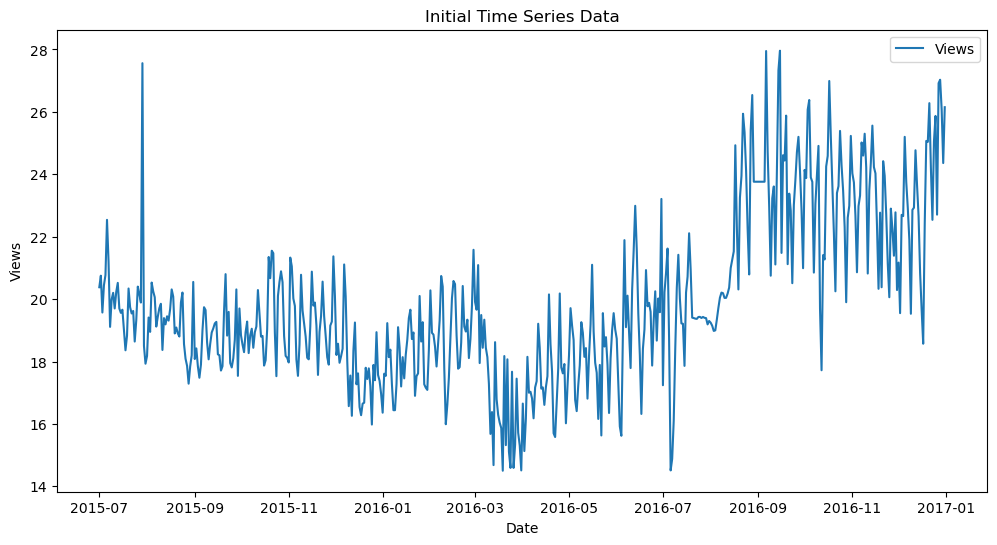

In [54]:
df = pd.read_csv('data.csv', parse_dates=['Date'], index_col='Date')

# Display the first few rows
print(df.head())

# Initial plot of the data
plt.figure(figsize=(12, 6))
plt.plot(df['Views'], label='Views')
plt.title('Initial Time Series Data')
plt.xlabel('Date')
plt.ylabel('Views')
plt.legend()
plt.show()


#### CHECKING FOR STATIONARITY

In [55]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['Views'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'{key}: {value}')


ADF Statistic: -0.4948656159141507
p-value: 0.893014548807699
Critical Values:
1%: -3.4426321555520905
5%: -2.86695748394138
10%: -2.5696553279762426


#### MAKING THE DATA STATIONARY

In [56]:
df['Views_diff'] = df['Views'].diff().dropna()

result_diff = adfuller(df['Views_diff'].dropna())
print('ADF Statistic (Differenced):', result_diff[0])
print('p-value (Differenced):', result_diff[1])
print('Critical Values (Differenced):')
for key, value in result_diff[4].items():
    print(f'{key}: {value}')


ADF Statistic (Differenced): -8.189701414241382
p-value (Differenced): 7.727194226782944e-13
Critical Values (Differenced):
1%: -3.4426321555520905
5%: -2.86695748394138
10%: -2.5696553279762426


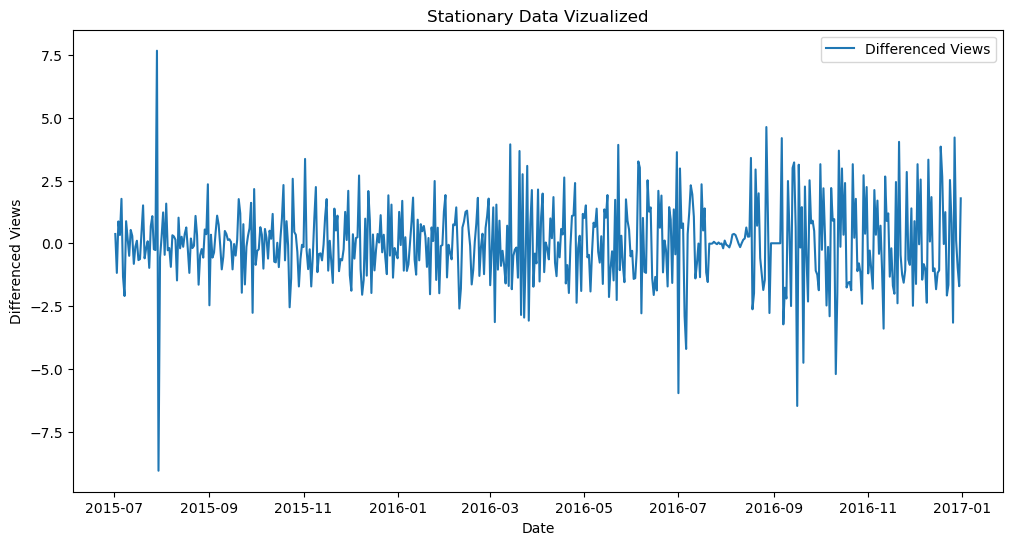

In [57]:
plt.figure(figsize=(12, 6))
plt.plot(df['Views_diff'], label='Differenced Views')
plt.title('Stationary Data Vizualized')
plt.xlabel('Date')
plt.ylabel('Differenced Views')
plt.legend()
plt.show()

#### USING AUTO ARIMA TO DETERMINE p, d, q

In [58]:
auto_model = pm.auto_arima(df['Views'], seasonal=False, stepwise=True, suppress_warnings=True)
print(auto_model.summary())

# Extract the order
p, d, q = auto_model.order
print(f'Best Order: p={p}, d={d}, q={q}')


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  550
Model:               SARIMAX(5, 1, 1)   Log Likelihood                -939.474
Date:                Wed, 29 May 2024   AIC                           1892.948
Time:                        16:53:33   BIC                           1923.105
Sample:                    07-01-2015   HQIC                          1904.734
                         - 12-31-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0238      0.070     -0.342      0.732      -0.160       0.113
ar.L2         -0.1730      0.048     -3.634      0.000      -0.266      -0.080
ar.L3         -0.3184      0.042     -7.568      0.0

###### Best Order: p=5, d=1, q=1

#### FIT THE ARIMA MODEL

In [59]:
model = ARIMA(df['Views'], order=(p, d, q))
results = model.fit()

#### GENERATE FORECASTS

In [60]:
# Forecast for the next 50 steps
forecast_steps = 50
forecast = results.get_forecast(steps=forecast_steps)
forecast_values = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Actual values for comparison (last 50 points)
actual_values = df['Views'][-forecast_steps:]


#### VIZUALIZE ACTUAL AND FORECASTED DATA

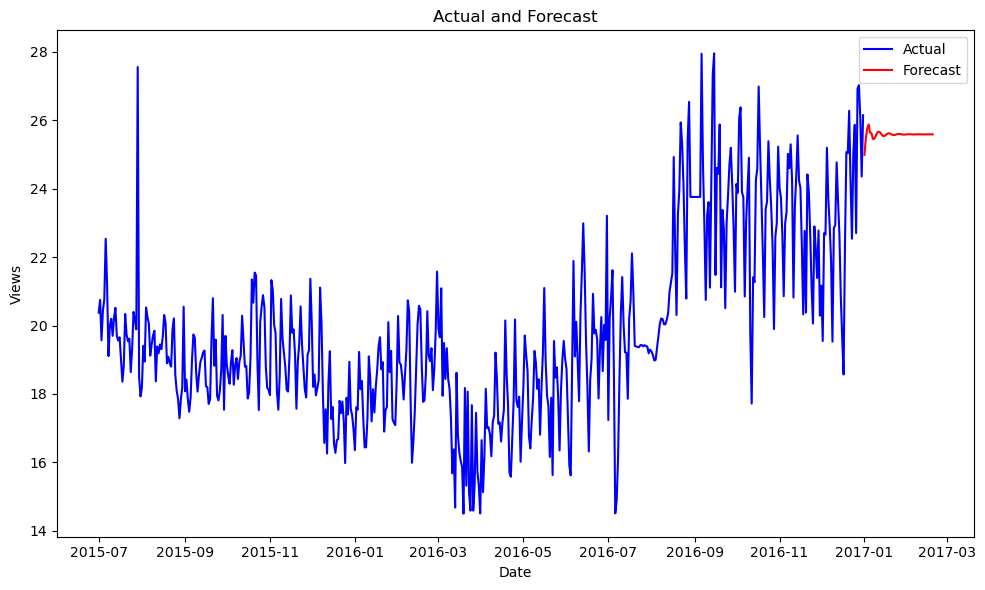

In [61]:
import matplotlib.pyplot as plt

# Plot actual vs. forecasted values
plt.figure(figsize=(10, 6))

# Plot actual data (full)
plt.plot(df.index, df['Views'], color='blue', label='Actual')
plt.title('Actual vs. Forecasted Views')
plt.ylabel('Views')
plt.legend()

# Plot zoomed-in forecasted values
plt.plot(forecast_values.index, forecast_values, color='red', label='Forecast')
plt.title('Actual and Forecast')
plt.xlabel('Date')
plt.ylabel('Views')
plt.legend()

plt.tight_layout()
plt.show()


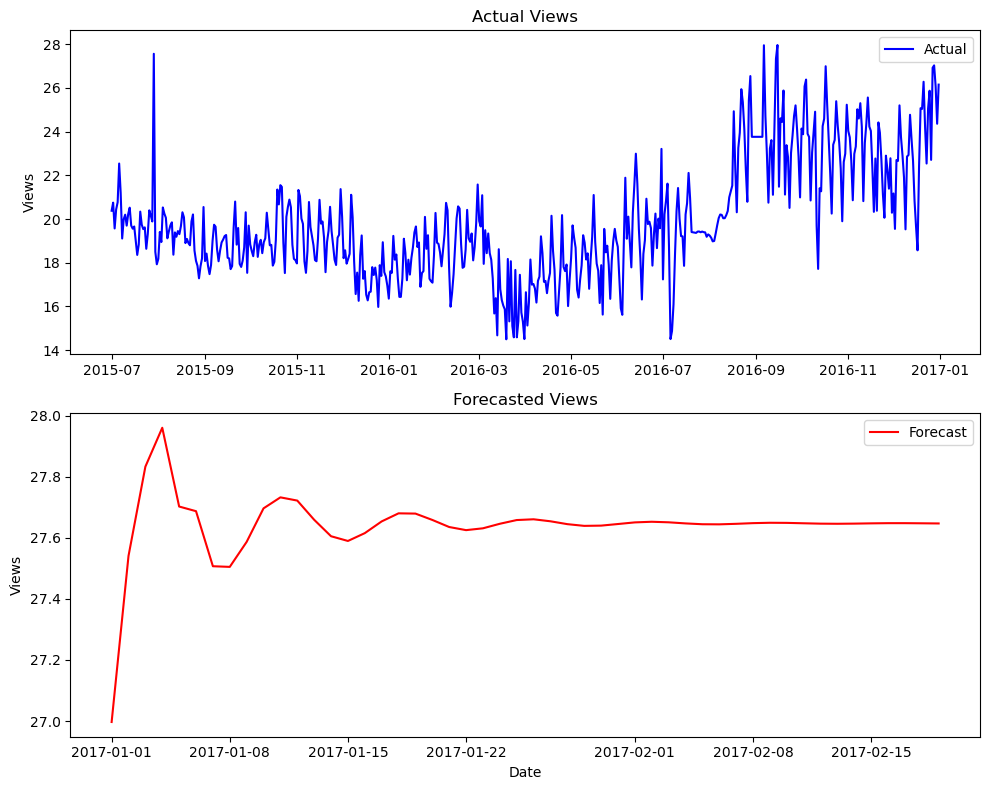

In [62]:
# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Plot actual data (full)
axs[0].plot(df.index, df['Views'], color='blue', label='Actual')
axs[0].set_title('Actual Views')
axs[0].set_ylabel('Views')
axs[0].legend()

# Plot forecasted values scaled to match sizes
scaled_forecast_values = forecast_values * (df['Views'].max() / forecast_values.max())
axs[1].plot(forecast_values.index, scaled_forecast_values, color='red', label='Forecast')
axs[1].set_title('Forecasted Views')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Views')
axs[1].legend()

# Share x-axis
plt.tight_layout()
plt.show()


#### EVALUATING THE MODEL

In [63]:
# Assuming last 10 values are actual for evaluation
actual_values = df['Views'][-10:]
forecast_values = forecast_values[-10:]

# Calculate evaluation metrics
mae = mean_absolute_error(actual_values, forecast_values)
rmse = mean_squared_error(actual_values, forecast_values, squared=False)

print("MAE:", mae)
print("RMSE:", rmse)


MAE: 1.3173676795183187
RMSE: 1.6067609433306822


##### *MAE: 1.3173676795183187*
##### *RMSE: 1.6067609433306822*

-----------------------------------------------------------------------

#### WE HAVE FORECASTED A POSSIBLE TREND FOR THE NEXT MONTH USING OUR ARIMA MODEL AND PROVIDED WEB TRAFFIC DATA, VIZUALIZED IT AND ALSO EVALUATED IT AGAINST METRICS.
